# Information Retrieval and Web Analytics
# PROJECT PART 1: Text Processing and Exploratory Data Analysis

Gerard Morales - NIA: 242781

Patricia Garay - NIA: 229260

Maren Clapers - NIA: 243397


In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Python packages

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
!pip install demoji

In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
from nltk.tokenize import word_tokenize
import time
import json
import pandas as pd
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
import demoji

## Load data into memory



In [ ]:
docs_path = '/content/drive/Shared drives/RIAW/Project/Part1/IRWA_data_2023/Rus_Ukr_war_data.json'

# Open and read the json file
with open(docs_path, 'r') as file:
    data = file.read()

# Split the content into individual JSON objects
# Each JSON object must be on a separate line
lines = data.strip().split('\n')

# Tweets dictionary identified by ID
tweets_dict = {}

for line in lines:
    tweet = json.loads(line)
    tweet_id = tweet['id']

    # For each tweet: Tweet | Date | Hashtags | Likes | Retweets | Url
    tweet_info = {
        "tweet_id": tweet_id,
        "tweet": tweet.get("full_text", ""),
        "date": tweet.get("created_at", ""),
        "hashtags": [tag["text"] for tag in tweet["entities"]["hashtags"]],
        "likes": tweet.get("favorite_count", 0), # 0 is the default value in case it does not exist
        "retweets": tweet.get("retweet_count", 0),
        "url": tweet['entities']['media'][0]['expanded_url'] if 'media' in tweet['entities'] else ""
    }

    tweets_dict[tweet_id] = tweet_info

In [ ]:
# Convert data into a DataFrame with Tweet | Date | Hashtags | Likes | Retweets | Url
tweets_list = list(tweets_dict.values())
tweets_df = pd.DataFrame(tweets_list)
tweets_df.head()

,tweet_id,tweet,date,hashtags,likes,retweets,url
0,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,Fri Sep 30 18:39:17 +0000 2022,"[RussiainvadesUkraine, UkraineRussiaWar]",0,0,
1,1575918081461080065,🇺🇦❤️ The Armed Forces liberated the village of...,Fri Sep 30 18:38:44 +0000 2022,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWa...",0,0,https://twitter.com/Feher_Junior/status/157591...
2,1575917992390823936,ALERT 🚨Poland preps anti-radiation tablets ove...,Fri Sep 30 18:38:23 +0000 2022,"[NATO, Putin, Russia, RussiaInvadedUkraine, Uk...",0,0,
3,1575917907774967809,I’m still waiting for my google map 🗺️ to upda...,Fri Sep 30 18:38:03 +0000 2022,"[Putin, UkraineRussiaWar]",0,0,
4,1575917878410301441,@EmmanuelMacron probably you're right or you h...,Fri Sep 30 18:37:56 +0000 2022,"[European, UkraineRussiaWar]",0,0,


In [ ]:
original_tweets_df = tweets_df.copy()

## Data pre-processing

In [ ]:
def build_terms(line):
    """
    Preprocess the tweets by removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    tokens - a list of tokens corresponding to the input text after the preprocessing
    """
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Remove URLs using a regular expression
    line = re.sub(r'http\S+|www\S+|https\S+', '', line)

    # Replace special characters
    line = line.replace('’', ' ').replace('“', ' ').replace('”', ' ').replace('‘', '')

    line = line.lower()  # Transform in lowercase
    line = demoji.replace(line, '')  # Remove emojis

    # Tokenize the text while preserving hashtags
    tokens = re.findall(r'\w+|#\w+', line)

    # Remove punctuation from words (excluding hashtags)
    tokens = [re.sub(r'[{}]'.format(string.punctuation), '', token) if not token.startswith('#') else token for token in tokens]

    tokens = [w for w in tokens if w not in stop_words]  # Eliminate stopwords
    tokens = [stemmer.stem(w) for w in tokens]  # Perform stemming

    return tokens

In [ ]:
## Apply the build_terms() function to the tweets of the dataFrame
tweets_df['tweet'] = tweets_df['tweet'].apply(build_terms)
## Convert 'Date' to a pandas datetime object
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df.head()

,tweet_id,tweet,date,hashtags,likes,retweets,url
0,1575918221013979136,"[melsimmonsfcdo, wrong, dictat, putin, fascist...",2022-09-30 18:39:17+00:00,"[RussiainvadesUkraine, UkraineRussiaWar]",0,0,
1,1575918081461080065,"[arm, forc, liber, villag, #drobyshev, #lymans...",2022-09-30 18:38:44+00:00,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWa...",0,0,https://twitter.com/Feher_Junior/status/157591...
2,1575917992390823936,"[alert, poland, prep, anti, radiat, tablet, nu...",2022-09-30 18:38:23+00:00,"[NATO, Putin, Russia, RussiaInvadedUkraine, Uk...",0,0,
3,1575917907774967809,"[still, wait, googl, map, updat, russia, new, ...",2022-09-30 18:38:03+00:00,"[Putin, UkraineRussiaWar]",0,0,
4,1575917878410301441,"[emmanuelmacron, probabl, right, say, anyway, ...",2022-09-30 18:37:56+00:00,"[European, UkraineRussiaWar]",0,0,


## Documents and Tweets mapping

In [ ]:
docs_id_path = '/content/drive/Shared drives/RIAW/Project/Part1/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'
tweet_document_ids = pd.read_csv(docs_id_path, sep='\t', header=None, names=['document_id', 'tweet_id'])
tweet_document_ids_df = pd.DataFrame(tweet_document_ids)
tweet_document_ids_df

,document_id,tweet_id
0,doc_1,1575918221013979136
1,doc_2,1575918081461080065
2,doc_3,1575917992390823936
3,doc_4,1575917907774967809
4,doc_5,1575917878410301441
...,...,...
3995,doc_3996,1575154617620504576
3996,doc_3997,1575154444165156864
3997,doc_3998,1575154440012812288
3998,doc_3999,1575154351273873410


In [ ]:
## Joining the dataframes 'tweets_df' and 'tweet_document_ids_df'
tweet_document_ids_map = pd.merge(tweets_df, tweet_document_ids_df, how='inner', on='tweet_id')
display(tweet_document_ids_map.head(5))

,tweet_id,tweet,date,hashtags,likes,retweets,url,document_id
0,1575918221013979136,"[melsimmonsfcdo, wrong, dictat, putin, fascist...",2022-09-30 18:39:17+00:00,"[RussiainvadesUkraine, UkraineRussiaWar]",0,0,,doc_1
1,1575918081461080065,"[arm, forc, liber, villag, #drobyshev, #lymans...",2022-09-30 18:38:44+00:00,"[Drobysheve, Lymansk, Donetsk, UkraineRussiaWa...",0,0,https://twitter.com/Feher_Junior/status/157591...,doc_2
2,1575917992390823936,"[alert, poland, prep, anti, radiat, tablet, nu...",2022-09-30 18:38:23+00:00,"[NATO, Putin, Russia, RussiaInvadedUkraine, Uk...",0,0,,doc_3
3,1575917907774967809,"[still, wait, googl, map, updat, russia, new, ...",2022-09-30 18:38:03+00:00,"[Putin, UkraineRussiaWar]",0,0,,doc_4
4,1575917878410301441,"[emmanuelmacron, probabl, right, say, anyway, ...",2022-09-30 18:37:56+00:00,"[European, UkraineRussiaWar]",0,0,,doc_5


## Exploratory Data Analysis

### Date Exploration

In [ ]:
## Dataframe with tweet_id | date | year | month | day
tweets_dates = tweets_df[['tweet_id', 'date']].copy()
tweets_dates["year"], tweets_dates["month"], tweets_dates["day"] = tweets_dates['date'].dt.year, tweets_dates['date'].dt.month, tweets_dates['date'].dt.day
tweets_dates.head()

,tweet_id,date,year,month,day
0,1575918221013979136,2022-09-30 18:39:17+00:00,2022,9,30
1,1575918081461080065,2022-09-30 18:38:44+00:00,2022,9,30
2,1575917992390823936,2022-09-30 18:38:23+00:00,2022,9,30
3,1575917907774967809,2022-09-30 18:38:03+00:00,2022,9,30
4,1575917878410301441,2022-09-30 18:37:56+00:00,2022,9,30


In [ ]:
# Year
tweets_dates["year"].unique()

array([2022])

In [ ]:
# Month
tweets_dates["month"].unique()

array([9])

In [ ]:
# Days
tweets_dates["day"].unique()

array([30, 29, 28])

### Word Counting Distribution

In [ ]:
word_counts = Counter(word for words in tweets_df['tweet'] for word in words)
# 10 most repeated words and their frequencies
common_words = word_counts.most_common(15)

print("The 15 most repeated words and hashtags and their frequencies:\n")
for word, frequency in common_words:
    print(f'{word}: {frequency}')

The 15 most repeated words and hashtags and their frequencies:

#ukrainerussiawar: 4013
#ukrain: 2429
#ukrainewar: 1310
#russia: 1250
ukrain: 1087
russian: 1022
#russian: 726
russia: 612
#putin: 552
putin: 511
ukrainian: 470
war: 468
#ukrainian: 460
#nato: 452
#kherson: 439


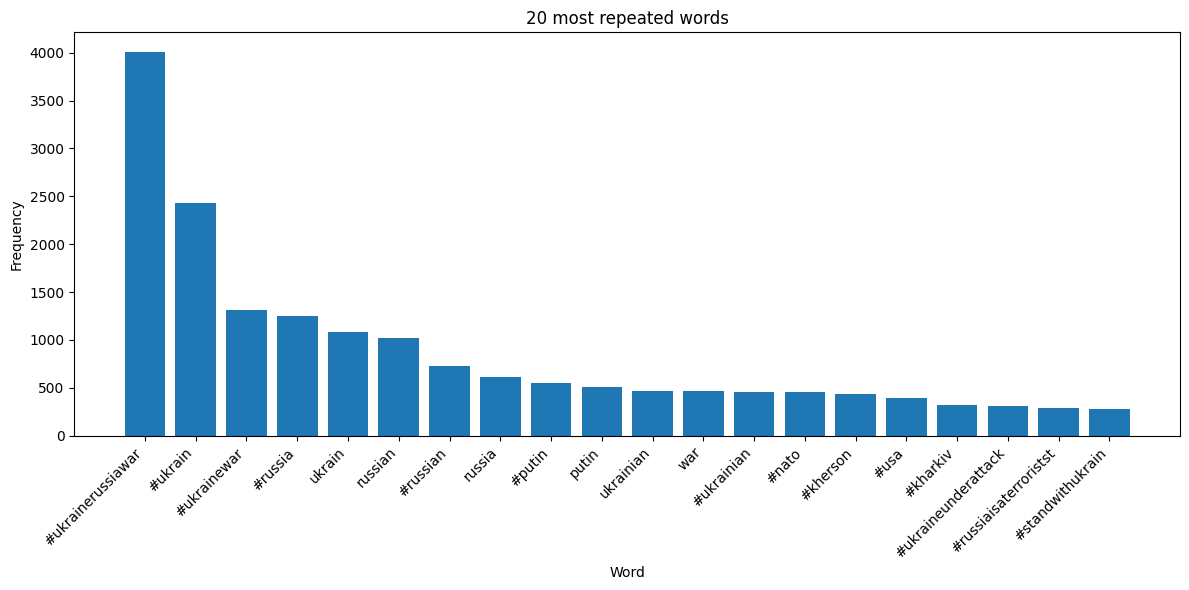

In [ ]:
# Bar graph to show the frequency of the 20 most common words
common_words = word_counts.most_common(20)
words, frequencies = zip(*common_words)

plt.figure(figsize=(12, 6))
plt.bar(range(len(words)), frequencies, tick_label=words)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('20 most repeated words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [ ]:
word_counts = Counter(word for words in tweets_df['tweet'] for word in words if not word.startswith('#'))
# 10 most repeated words and their frequencies
common_words = word_counts.most_common(15)

print("The 15 most repeated words and their frequencies:\n")
for word, frequency in common_words:
    print(f'{word}: {frequency}')

The 15 most repeated words and their frequencies:

ukrain: 1087
russian: 1022
russia: 612
putin: 511
ukrainian: 470
war: 468
forc: 277
region: 253
amp: 230
annex: 228
video: 221
peopl: 218
territori: 175
us: 174
militari: 167


### Average Tweet Length

In [ ]:
#Funcion that returns the avg word count of the tweets
def avg_tweet_len(tweets_df):
  count = 0
  for tweet in tweets_df['tweet']:
    count += len(tweet)
  return count/len(tweets_df)

In [ ]:
print("Average Tweet Word Length:", avg_tweet_len(tweets_df))

Average Tweet Word Length: 17.45775


### Average Tweet Character Lenght

In [ ]:
#Funcion that returns the avg character count of the tweets
def avg_tweet_char(tweets_df):
  count = 0
  for tweet in tweets_df['tweet']:
    for word in tweet:
      count += len(word)
  return count/len(tweets_df)

In [ ]:
print("Average Number of Characters in a Tweet:", avg_tweet_char(tweets_df))

Average Number of Characters in a Tweet: 129.2645


### Vocabulary Size

In [ ]:
## Distribution of unique words
unique_word_count = len(word_counts)
print(f'Number of unique words in the corpus: {unique_word_count}')

Number of unique words in the corpus: 6506


### Ranking of most Retweeted and most Liked Tweets



In [ ]:
def top_10(aspect, tweets_df):
  ordered_df = tweets_df.sort_values(by=aspect, ascending=False)
  top_10 = ordered_df.iloc[:10, :]
  print("Top 10 Tweets with most", aspect, ':\n')
  for i in range(len(top_10)):
    #To display the tweet id, the content and number of likes/retweets
    print('\n', i+1, '. tweet_id:', top_10['tweet_id'].iloc[i], '\n     Tweet:', top_10['tweet'].iloc[i], '\n     Number of', aspect, ':', top_10[aspect].iloc[i], '\n')

In [ ]:
#Displays the top 10 tweets with most likes
top_10('likes', tweets_df)
#Displays the top 10 tweets with most likes
top_10('retweets', tweets_df)

Top 10 Tweets with most likes :


 1 . tweet_id: 1575775162674212865 
     Tweet: ['situat', 'around', 'lyman', 'sep', '30', '11', '00', 'ua', 'forc', 'liber', 'yampil', 'advanc', 'north', 'ru', 'troop', 'reportedli', 'abandon', 'posit', 'drobyshev', 'exit', 'rout', 'lyman', 'within', 'fire', 'rang', 'ua', 'forc', '#ukrainerussiawar'] 
     Number of likes : 3701 


 2 . tweet_id: 1575396903252025351 
     Tweet: ['uniqu', 'rare', 'photo', 'ukrainian', 'forward', 'command', 'post', 'offens', '#kharkiv', 'oblast', 'news', 'report', 'usual', 'invit', 'place', 'seem', 'except', '#ukrainerussiawar'] 
     Number of likes : 2685 


 3 . tweet_id: 1575181552170201088 
     Tweet: ['oper', 'interflex', 'ukrainian', 'recruit', 'continu', 'master', 'skill', 'guidanc', 'british', 'canadian', 'instructor', 'uk', '#ukrainerussiawar'] 
     Number of likes : 2155 


 4 . tweet_id: 1575391586422243333 
     Tweet: ['czech', 'volunt', 'ongo', 'offens', 'ukrainian', 'forc', '#kharkiv', 'oblast', '#ukr

### Word Cloud

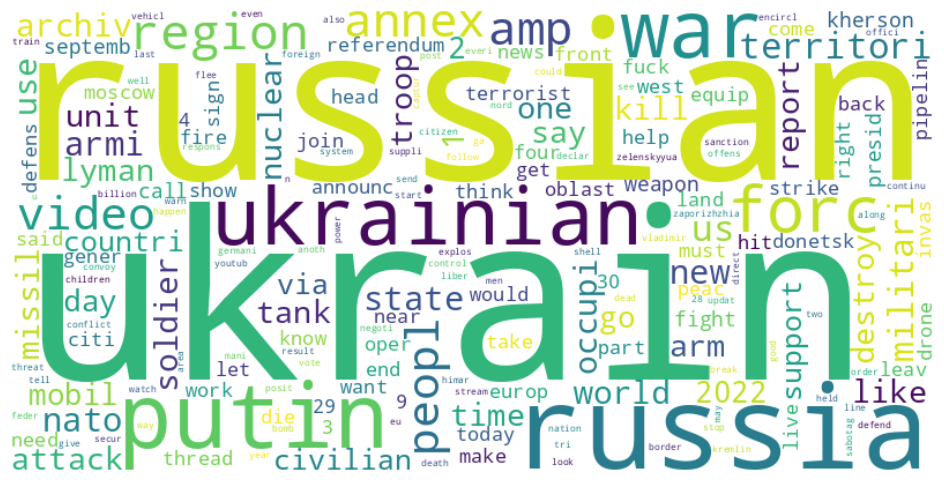

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Entity Recognition

In [ ]:
#Function to get unique values from entities_list
def unique(list):

  unique_list = []

  for x in list:
    #Checks if exists in unique_list or not
    if x not in unique_list:
        unique_list.append(x)

  return unique_list

In [ ]:
nlp = spacy.load("en_core_web_sm")

entities_list = []

for tweet_list in tweets_df['tweet']:
  for tweet in tweet_list:
    doc = nlp(tweet)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    entities_list.append(entities)

In [ ]:
unique_entities = unique(entities_list)
unique_entities

[[],
 [('putin', 'PERSON')],
 [('russia', 'GPE')],
 [('ukrainewillwin', 'MONEY')],
 [('#', 'CARDINAL')],
 [('poland', 'GPE')],
 [('nato', 'ORG')],
 [('#', 'CARDINAL'), ('european', 'NORP')],
 [('estonia', 'GPE')],
 [('lithuania', 'GPE')],
 [('latvia', 'GPE')],
 [('fulli', 'PERSON')],
 [('russian', 'NORP')],
 [('moscow', 'GPE')],
 [('russianukrainianwar', 'PERSON')],
 [('#ww3', 'PERCENT')],
 [('berlin', 'GPE')],
 [('brussel', 'ORG')],
 [('london', 'GPE')],
 [('stockholm', 'GPE')],
 [('pari', 'PERSON')],
 [('90', 'CARDINAL')],
 [('thousand', 'CARDINAL')],
 [('15', 'CARDINAL')],
 [('boundari', 'ORG')],
 [('turkey', 'GPE')],
 [('four', 'CARDINAL')],
 [('1½', 'CARDINAL')],
 [('lyman', 'PERSON')],
 [('29', 'CARDINAL')],
 [('30', 'CARDINAL')],
 [('torsk', 'PERSON')],
 [('yampil', 'PERSON')],
 [('liman', 'PERSON')],
 [('finland', 'GPE')],
 [('zaporizhzhia', 'MONEY')],
 [('88', 'CARDINAL')],
 [('27', 'CARDINAL')],
 [('armi', 'ORG')],
 [('israel', 'GPE')],
 [('2', 'CARDINAL')],
 [('mariupol', 'M

In [ ]:
#The total number of unique entities:
len(unique_entities)

1540

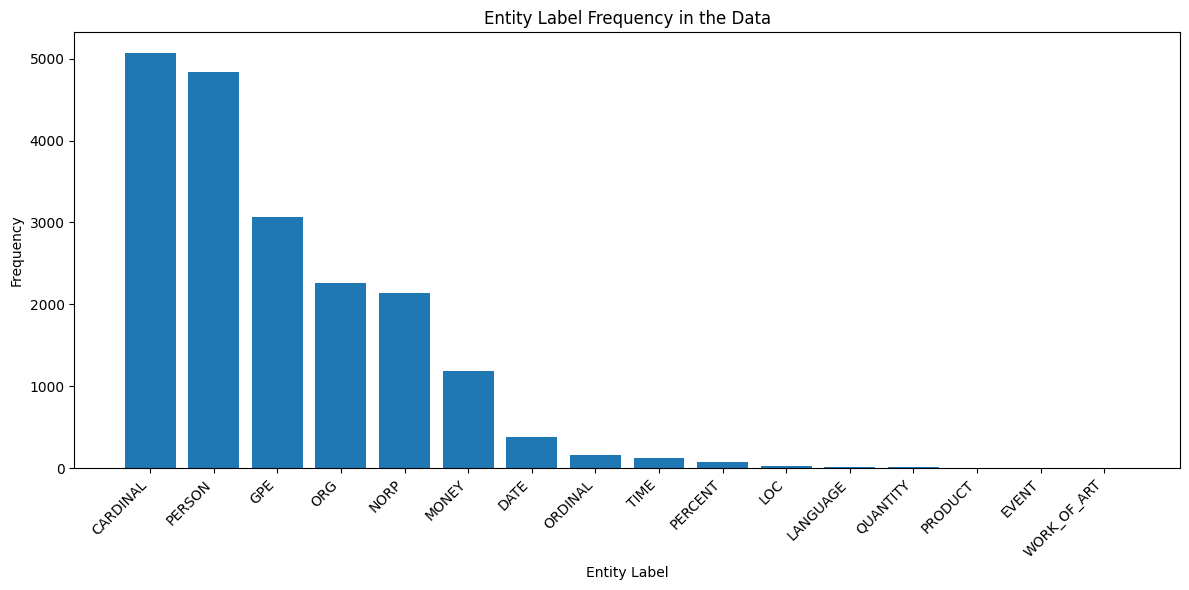

In [ ]:
#First, flatten the list of entities
flat_entities = [item for sublist in entities_list for item in sublist]

#Count the frequency of each entity label
label_counter = Counter(label for _, label in flat_entities)

#Extract labels and their counts
labels, counts = zip(*label_counter.items())

#Sort the labels and counts by frequency
labels, counts = zip(*sorted(zip(labels, counts), key=lambda x: x[1], reverse=True))

#Bar chart to show the frequency of the different entities
plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xlabel('Entity Label')
plt.ylabel('Frequency')
plt.title('Entity Label Frequency in the Data')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()



In [ ]:
label_counter

Counter({'PERSON': 4841,
         'GPE': 3062,
         'MONEY': 1189,
         'CARDINAL': 5068,
         'ORG': 2257,
         'NORP': 2139,
         'PERCENT': 73,
         'ORDINAL': 161,
         'QUANTITY': 10,
         'TIME': 125,
         'DATE': 376,
         'WORK_OF_ART': 1,
         'LOC': 21,
         'LANGUAGE': 17,
         'PRODUCT': 8,
         'EVENT': 2})